#Exercise 2

In [10]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.datasets import make_swiss_roll
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import seaborn as sns

In [11]:
# load swiss roll dataset
X, y = make_swiss_roll(n_samples=2000, random_state=42)
print(X.shape)
print(X[0])

(2000, 3)
[-3.12117466  5.49581936  7.62853482]


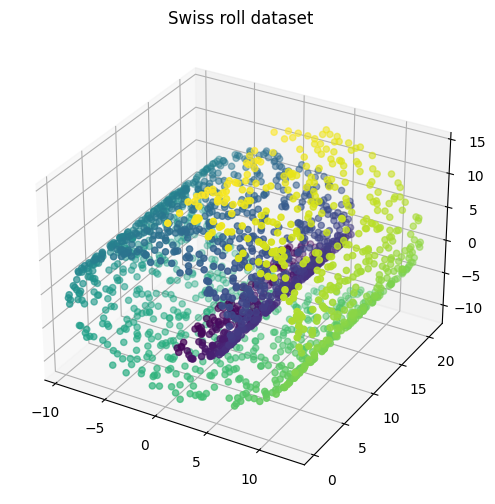

In [12]:
# plot the swiss roll
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d") # 111: shorthand notation for rows, columns, plot_number
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y)
ax.set_title("Swiss roll dataset")
plt.show()

In [13]:
# linear kernel pca
kpca_linear = KernelPCA(kernel="linear", n_components=2)
X_kpca_linear = kpca_linear.fit_transform(X)
print(f"linear: {X_kpca_linear.shape}")

# rbf kernel pca
kpca_rbf = KernelPCA(kernel="rbf", n_components=2)
X_kpca_rbf = kpca_rbf.fit_transform(X)
print(f"rbf: {X_kpca_rbf.shape}")

# sigmoid kernel pca
kpca_sigmoid = KernelPCA(kernel="sigmoid", n_components=2)
X_kpca_sigmoid = kpca_sigmoid.fit_transform(X)
print(f"sigmoid: {X_kpca_sigmoid.shape}")

linear: (2000, 2)
rbf: (2000, 2)
sigmoid: (2000, 2)


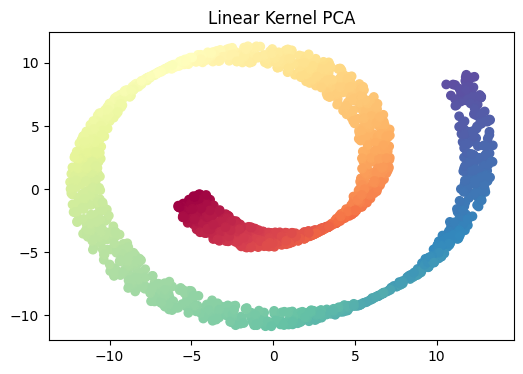

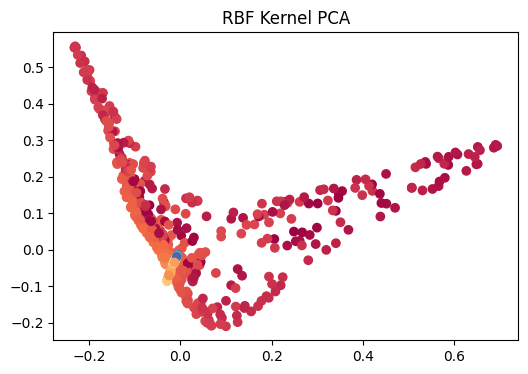

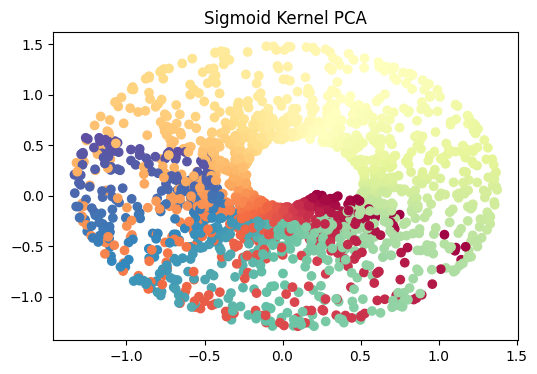

In [14]:
# plot linear kernel pca
plt.figure(figsize=(6, 4))
plt.scatter(X_kpca_linear[:, 0], X_kpca_linear[:, 1], c=y, cmap=plt.cm.Spectral)
plt.title("Linear Kernel PCA")
plt.show()

# plot rbf kernel pca
plt.figure(figsize=(6, 4))
plt.scatter(X_kpca_rbf[:, 0], X_kpca_rbf[:, 1], c=y, cmap=plt.cm.Spectral)
plt.title("RBF Kernel PCA")
plt.show()

# plot sigmoid kernel pca
plt.figure(figsize=(6, 4))
plt.scatter(X_kpca_sigmoid[:, 0], X_kpca_sigmoid[:, 1], c=y, cmap=plt.cm.Spectral)
plt.title("Sigmoid Kernel PCA")
plt.show()

In [15]:
# create and fit encoder (continous to discrete)
encoder = KBinsDiscretizer(n_bins=6, encode="ordinal", strategy="uniform")
y_encoded = encoder.fit_transform(y.reshape(-1, 1))
y_encoded = y_encoded.ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# scale sets
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# create and configure pipeline
pipeline = Pipeline([
    ("kpca", KernelPCA(n_components=3)),
    ("logreg", LogisticRegression())
])

param_grid = {
    "kpca__kernel": ["linear", "rbf", "sigmoid"],
    "kpca__gamma": [0.001, 0.01, 0.1, 1, 10, 100]
}

# create and run grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring="accuracy")
grid_search.fit(X_train_scaled, y_train)

print("Best params: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best params:  {'kpca__gamma': 0.001, 'kpca__kernel': 'linear'}
Best score:  0.991876945562887


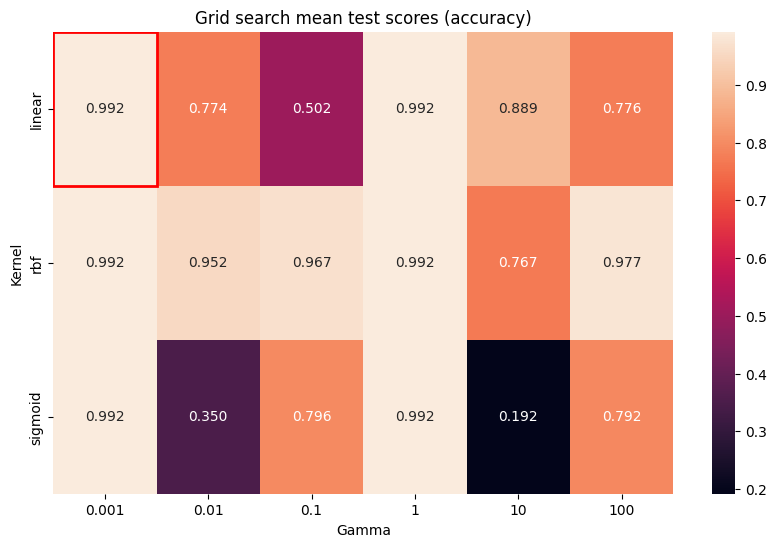

In [16]:
# extract the results from grid search and creatt heatmap
results = grid_search.cv_results_
param_kernel = np.unique(results["param_kpca__kernel"])
param_gamma = np.unique(results["param_kpca__gamma"])
mean_test_score = results["mean_test_score"].reshape(len(param_kernel), len(param_gamma))

plt.figure(figsize=(10, 6))
sns.heatmap(mean_test_score, annot=True, fmt=".3f", xticklabels=param_gamma, yticklabels=param_kernel)

# highlight cell with best parameters
best_param_index = np.unravel_index(np.argmax(mean_test_score), mean_test_score.shape)
plt.gca().add_patch(plt.Rectangle((best_param_index[1], best_param_index[0]), 1, 1, fill=False, edgecolor="red", lw=2))

plt.xlabel("Gamma")
plt.ylabel("Kernel")
plt.title(f"Grid search mean test scores (accuracy)")
plt.show()

In [17]:
# predict on test set and check score
y_pred = grid_search.predict(X_test_scaled)
print("Score on test set: ", accuracy_score(y_test, y_pred))

Score on test set:  0.9925


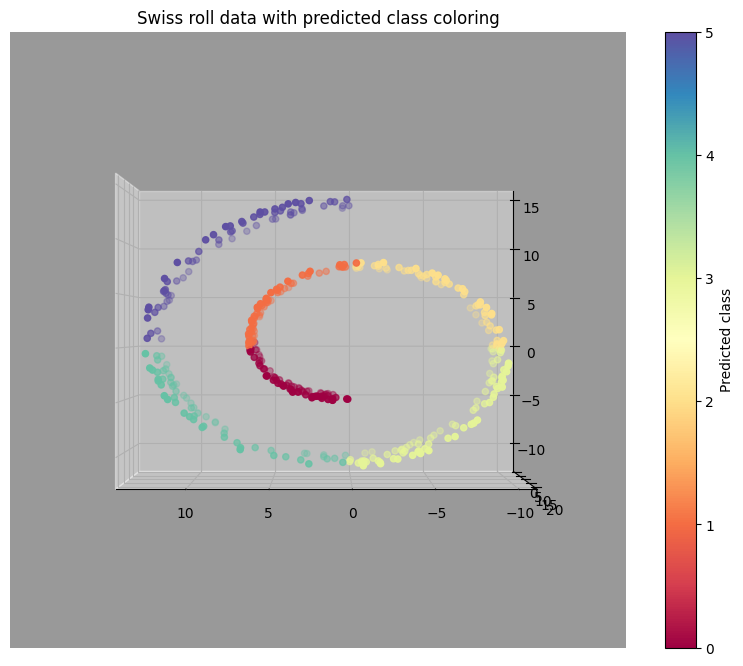

In [18]:
# create scatter plot of predicted classes
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
ax.set_facecolor((0.6, 0.6, 0.6))
ax.view_init(elev=0, azim=90)
scatter = ax.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2], c=y_pred, cmap=plt.cm.Spectral)
plt.title("Swiss roll data with predicted class coloring")
plt.colorbar(scatter, label="Predicted class")
plt.show()